Shape of rdf_11.results.count: (200,)
Shape of norm_factor: (199,)
Shape of rdf_11.results.count: (200,)
Shape of norm_factor: (199,)
Shape of rdf_11.results.count: (200,)
Shape of norm_factor: (199,)
Shape of rdf_11.results.count: (200,)
Shape of norm_factor: (199,)
Shape of rdf_11.results.count: (200,)
Shape of norm_factor: (199,)
Shape of rdf_11.results.count: (200,)
Shape of norm_factor: (199,)
Shape of rdf_11.results.count: (200,)
Shape of norm_factor: (199,)
Shape of rdf_11.results.count: (200,)
Shape of norm_factor: (199,)
Shape of rdf_11.results.count: (200,)
Shape of norm_factor: (199,)


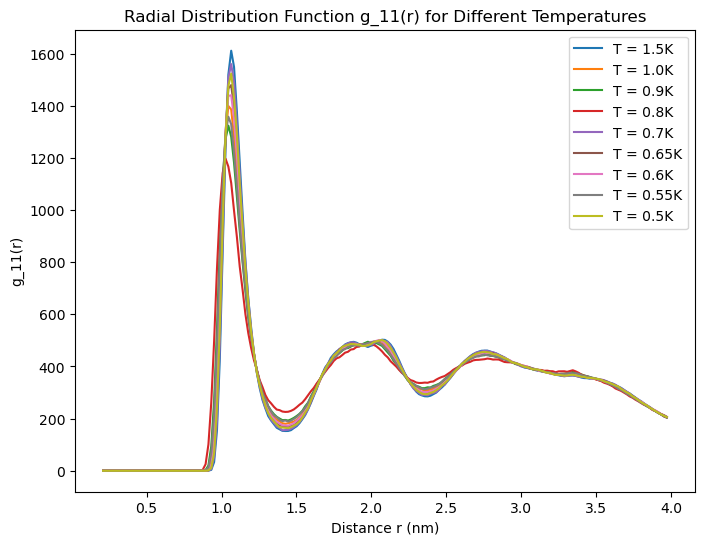

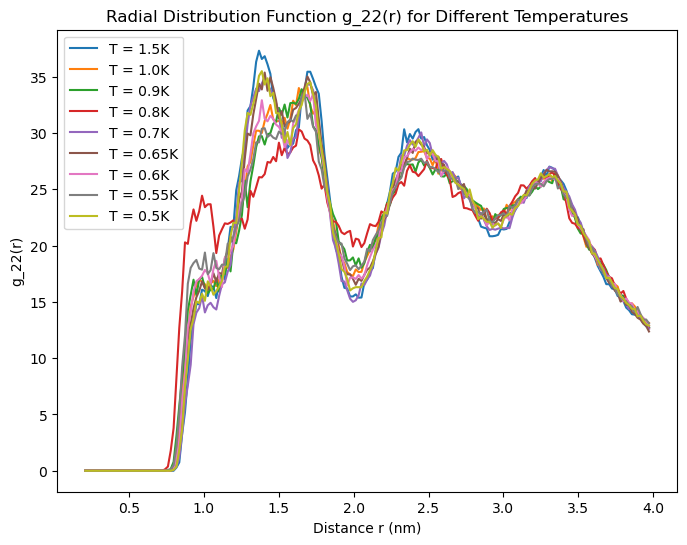

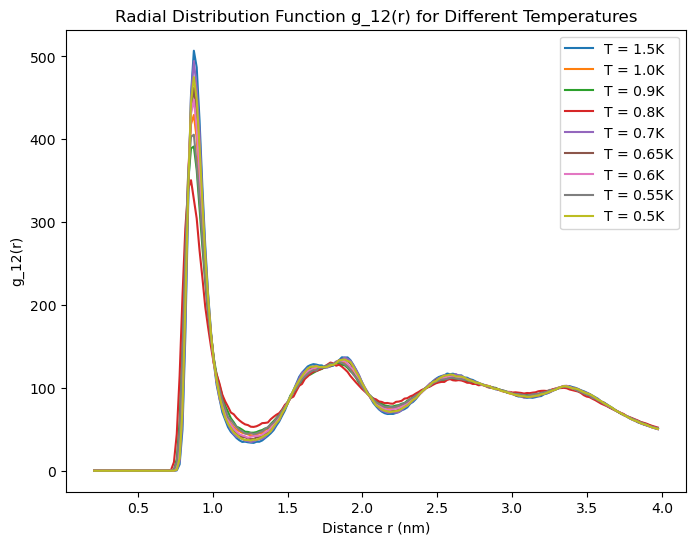

In [11]:
import MDAnalysis as mda
import glob
import matplotlib.pyplot as plt
from MDAnalysis.analysis import rdf
import numpy as np

# Define the directory containing trajectory and topology files
trajectory_files = glob.glob("../Inputs/prod/*kalj*.xyz")
topology_file = glob.glob("../Inputs/equil/*kalj*.lammpstrj")[0]

# Initialize the mass dictionary
mass_dict = {1: 39.95, 2: 40.08}  # Customize these values if needed

# Set up RDF analysis for each temperature
rdf_data = {'11': [], '22': [], '12': []}
r_values = None
selections = {"type1": "type 1", "type2": "type 2"}  # Update selections if needed

# Define the box dimensions
box_dimensions = [6.6943295008216896, 6.6943295008216896, 6.6943295008216896, 90.0, 90.0, 90.0]
box_volume = np.prod(box_dimensions[:3])

for temp, traj_file in zip([1.5, 1.0, 0.9, 0.8, 0.7, 0.65, 0.6, 0.55, 0.5], trajectory_files):
    universe = mda.Universe(topology_file, traj_file, topology_format="LAMMPSDUMP")
    universe.dimensions = box_dimensions  # Set box dimensions

    # Assign masses
    for atom in universe.atoms:
        atom.mass = mass_dict.get(atom.type, 1.0)  # Default to 1.0 if type not in dict

    # Select atom groups
    group1 = universe.select_atoms(selections["type1"])
    group2 = universe.select_atoms(selections["type2"])
    
    # Calculate expected density
    number_density = len(universe.atoms) / box_volume

    # Adjust RDF parameters
    rdf_11 = rdf.InterRDF(group1, group1, nbins=200, range=(0.2, 4.0))  # Start range at 0.2 nm to avoid overlaps
    rdf_22 = rdf.InterRDF(group2, group2, nbins=200, range=(0.2, 4.0))
    rdf_12 = rdf.InterRDF(group1, group2, nbins=200, range=(0.2, 4.0))

    # Run RDF calculations
    try:
        rdf_11.run()
        rdf_22.run()
        rdf_12.run()
    except ZeroDivisionError:
        print(f"ZeroDivisionError encountered at T = {temp}K. Skipping this temperature.")
        continue

    # Store RDF data and radius values
    if r_values is None:
        r_values = rdf_11.results.bins

    # Manual normalization check
    volume_bins = (4/3) * np.pi * (r_values[1:]**3 - r_values[:-1]**3)  # Shape (199,)
    norm_factor = number_density * len(group1) * volume_bins  # Shape (199,)

    # Check shapes for debugging
    print(f"Shape of rdf_11.results.count: {rdf_11.results.count.shape}")  # (200,)
    print(f"Shape of norm_factor: {norm_factor.shape}")  # (199,)

    # Normalize RDF results manually to compare
    rdf_11_normalized = rdf_11.results.count[:-1] / norm_factor  # Use only the first 199 values
    rdf_22_normalized = rdf_22.results.count[:-1] / norm_factor  # Use only the first 199 values
    rdf_12_normalized = rdf_12.results.count[:-1] / norm_factor  # Use only the first 199 values

    rdf_data['11'].append((temp, rdf_11_normalized))
    rdf_data['22'].append((temp, rdf_22_normalized))
    rdf_data['12'].append((temp, rdf_12_normalized))

# Plotting function
def plot_rdf(r_values, rdf_data, pair_type):
    plt.figure(figsize=(8, 6))
    for temp, rdf_values in rdf_data[pair_type]:
        plt.plot(r_values[:-1], rdf_values, label=f"T = {temp}K")  # Exclude last bin (normalization step)
    plt.xlabel("Distance r (nm)")
    plt.ylabel(f"g_{pair_type}(r)")
    plt.legend()
    plt.title(f"Radial Distribution Function g_{pair_type}(r) for Different Temperatures")
    plt.show()

# Plot RDFs for each pair type at different temperatures
plot_rdf(r_values, rdf_data, '11')
plot_rdf(r_values, rdf_data, '22')
plot_rdf(r_values, rdf_data, '12')
